## Resumo Aula 4 ML3 ##

# Técnicas de Engenharia de Atributos

É frequente encontrarmos situações onde existe a necessidade de *criar mais atributos* ao invés de eliminá-los. Isso é muito comum em conjuntos de dados em que as funções podem ser difíceis de serem estabelecidas. A criação de atributos é comumente aplicada na etapa de análise exploratória dos dados.

O nome oficial dado a esse processo é *Engenharia de Atributos* - (literatura: *Feature Engineering*). Dentre as formas de se melhorar o desempenho de modelos, diria que a engenharia de atributos está entre as mais eficazes.

- Conceito de *Feature Engineering*
- Feature Engineering na Análise Exploratória de Dados
- Algumas formas de Feature Engineering
    - Conhecimento de Negócio
    - Transformações para Distribuições Específicas
    - Discretização
    - Atributos Polinomiais
    - Séries Temporais
- Feature Engineering no Pipeline

## **1. Conceito de Feature Engineering**

A engenharia de atributos é, por definição, qualquer transformação aplicada aos dados brutos, levando-os a um patamar onde sua nova representação permita a extração de conhecimento e a sua modelagem, muitas vezes melhorando o desempenho do modelo em dados nunca vistos. Essencialmente, transformar dados brutos em atributos que melhor representam o conhecimento.

<img src="https://image.slidesharecdn.com/featureengineering-171206213206/95/feature-engineering-6-638.jpg?cb=1512596023">

A engenharia de atributos também permitir a utilização de modelos mais simples, o que sempre ajuda do ponto de vista de custo de disponibilização em produção, desempenho, escalabilidade e também na interpretabilidade dos resultados.

Em nossas aulas anteriores, fizemos alguns exemplos bem simples de engenharia de atributos, como por exemplo, a codificação das variáveis categóricas (*LabelEncoding*, *OneHotEncoding*) e também o escalonamento dos atributos (*MinMaxScaler*, *StandardScaler*, *RobustScaler*). Essas transformações são processamentos feitos aos dados para permitir o treinamento dos modelos e reduzir o viés da amostragem dos dados, mas podem ser consideradas como ferramentas de engenharia de atributos.

## **2. Feature Engineering na Análise Exploratória de Dados**

As transformações de variáveis podem ser utilizadas durante a etapa de Análise Exploratória de Dados para gerar conhecimento a respeito dos dados. Podemos deduzir ou ter uma aproximação da função geradora dos dados observando características do seu comportamento, por meio das transformações. Vejamos um exemplo, proveniente da área de Engenharia das Reações Químicas. O problema em questão é a medida da velocidade de reação química em diversas temperaturas, passo fundamental para se realizar o dimensionamento de um reator químico.

Nesse exemplo prático, vamos estudar a velocidade de decomposição do cloreto de benzeno diazônio, um composto bem utilizado na produção de alguns tipos de corantes. No entanto, ele é bem suscetível à decomposição e sua reação é violenta, podendo produzir explosões, com extrema liberação de energia. Por isso, é muito importante conhecer o modelo que descreve a velocidade de reação em função de temperatura, de modo que se pode projetar controles eficientes de temperatura para a utilização desse componente químico.

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing as pp
from sklearn.datasets import load_iris, fetch_openml
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score


# ignorar warnings
warnings.filterwarnings('ignore')

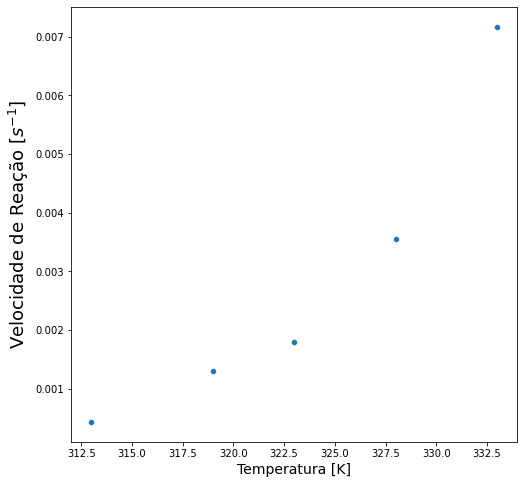

In [2]:
# dados de laboratório - reação de decomposição de cloreto de benzeno diazônio em clorobenzeno e nitrogênio
k = [0.00043, 0.0013, 0.00180, 0.00355, 0.00717]
T = [313, 319, 323, 328, 333]

# visualizando dados
plt.figure(figsize=(8, 8))
sns.scatterplot(T, k)
plt.xlabel('Temperatura [K]', size=14)
plt.ylabel('Velocidade de Reação [' + r'$s^{-1}$]', size=18)
plt.show()

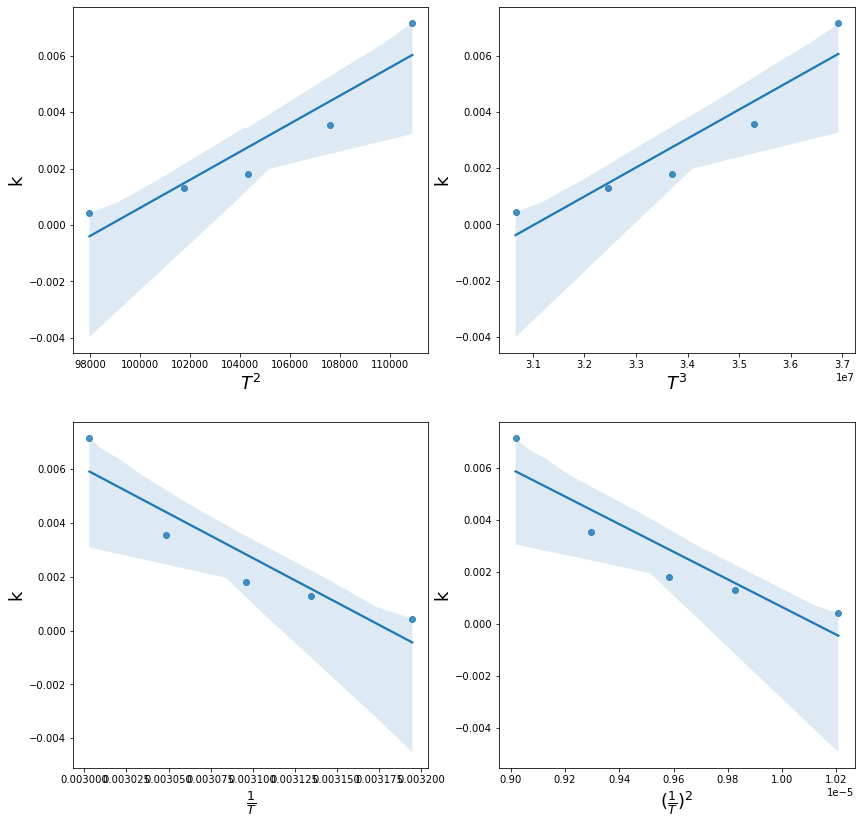

In [3]:
# vamos tentar algumas modificações da temperatura
data = pd.DataFrame(T, columns=['T'])
data['k'] = k


# criando figuras de transformações
fig = plt.figure(figsize=(14, 14))

ax = fig.add_subplot(2, 2, 1)
sns.regplot(data['T'] ** 2, k)
ax.set_xlabel(r'$T^2$', size=18)
ax.set_ylabel('k', size=18)

ax = fig.add_subplot(2, 2, 2)
sns.regplot(data['T'] ** 3, k)
ax.set_xlabel(r'$T^3$', size=18)
ax.set_ylabel('k', size=18)

ax = fig.add_subplot(2, 2, 3)
sns.regplot(1 / data['T'], k)
ax.set_xlabel(r'$\frac{1}{T}$', size=18)
ax.set_ylabel('k', size=18)

ax = fig.add_subplot(2, 2, 4)
sns.regplot((1 / data['T']) ** 2, k)
ax.set_xlabel(r'$(\frac{1}{T})^2$', size=18)
ax.set_ylabel('k', size=18)

plt.show()

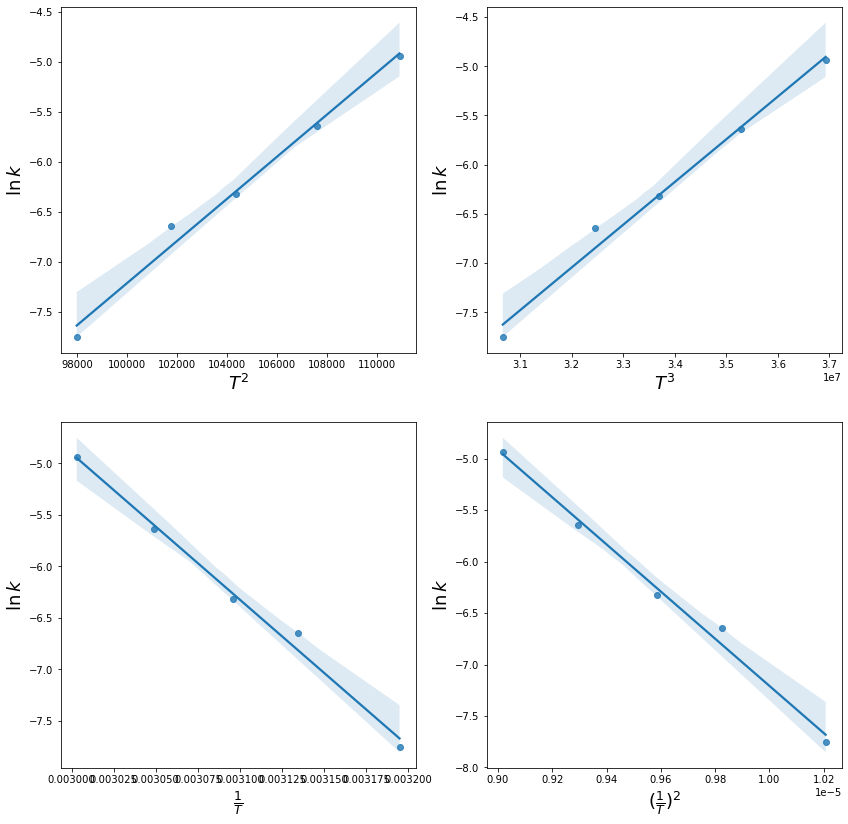

In [4]:
# vamos tentar agora com o k em escala logaritmica
fig = plt.figure(figsize=(14, 14))

ax = fig.add_subplot(2, 2, 1)
sns.regplot(data['T'] ** 2, np.log(k))
ax.set_xlabel(r'$T^2$', size=18)
ax.set_ylabel(r'$\ln{k}$', size=18)

ax = fig.add_subplot(2, 2, 2)
sns.regplot(data['T'] ** 3, np.log(k))
ax.set_xlabel(r'$T^3$', size=18)
ax.set_ylabel(r'$\ln{k}$', size=18)

ax = fig.add_subplot(2, 2, 3)
sns.regplot(1 / data['T'], np.log(k))
ax.set_xlabel(r'$\frac{1}{T}$', size=18)
ax.set_ylabel(r'$\ln{k}$', size=18)

ax = fig.add_subplot(2, 2, 4)
sns.regplot((1 / data['T']) ** 2, np.log(k))
ax.set_xlabel(r'$(\frac{1}{T})^2$', size=18)
ax.set_ylabel(r'$\ln{k}$', size=18)

plt.show()

In [5]:
# realizando engenharia no dataset e testando modelos
data['T**2'] = data['T'] ** 2
data['T**3'] = data['T'] ** 3
data['1 / T'] = 1 / data['T']
data['(1 / T) ** 2'] = (1 / data['T']) ** 2

data['ln_k'] = np.log(data['k'])

In [6]:
for col_x in ['T', 'T**2', 'T**3', '1 / T', '(1 / T) ** 2']:
    for col_y in ['k', 'ln_k']:
        
        # construindo modelo
        model_pipe = Pipeline([
            ('scaler', pp.StandardScaler()),
            ('model', LinearRegression())
        ])

        # ajusta modelo
        model_pipe.fit(data[[col_x]], data[[col_y]])

        # avalia modelo
        print(f'Desempenho do modelo {col_y} x {col_x}: {r2_score(data[[col_y]], model_pipe.predict(data[[col_x]]))}')

Desempenho do modelo k x T: 0.8657593179396331
Desempenho do modelo ln_k x T: 0.9894073452042317
Desempenho do modelo k x T**2: 0.871898629622174
Desempenho do modelo ln_k x T**2: 0.9884201073423139
Desempenho do modelo k x T**3: 0.877910815976322
Desempenho do modelo ln_k x T**3: 0.9872670691586437
Desempenho do modelo k x 1 / T: 0.8531179577849042
Desempenho do modelo ln_k x 1 / T: 0.9908793028124878
Desempenho do modelo k x (1 / T) ** 2: 0.8466258675115587
Desempenho do modelo ln_k x (1 / T) ** 2: 0.9913623155267449


A lei que descreve a velocidade de uma reação química em função da temperatura é a Lei de Arrhenius, dada por:

$$k(T) = A exp\Bigg(\frac{-E_A}{RT}\Bigg) \to \ln{k(T)} = \ln{A} - \frac{E_A}{RT} \to \ln{k(T)} = a + b \frac{1}{T}$$

## **3. Algumas Formas de Feature Engineering**

Verificamos que podemos estimar a função geradora ou então a relação entre duas variáveis aplicando e modificando as transformações. Nota-se também que a engenharia de atributos é um passo muito dependente do conhecimento específico do negócio - nesse caso, da engenharia química. No entanto, existem algumas técnicas que podem ser aplicadas para fazer o que chamamos de *Automatic Feature Engineering*.

A engenharia automática de atributos pode servir para realizar testes rápidos e, como o próprio nome diz, automatizados, ajudando o modelador a ter mais informações a respeito da base de dados e como se comportam as relações entre as variáveis. A primeira forma de engenharia de atributos, que já vimos, depende bastante do conhecimento de negócios e pode ser aplicada de forma direta, realizando-se cálculos com as colunas do dataset. Vejamos alguns exemplos.

### **3.1. Conhecimento de Negócio**

Nesta parte, além de cálculos diretos, podem ser realizados cálculos matemáticos como agrupamentos por categoria e diferenças em relação à uma média. Geralmente, esse tipo de transformação tende a ser bem dependente de relações já conhecidas pelo negócio, ou proveniente de discussões com o cliente, especialistas da área e pessoas mais sênior. Outros exemplos além do apresentado:

- cálculo do IMC para área médica;
- cálculo do PIB *per capita*, ou qualquer outra estatística *per capita* para estudos econômicos ou sociológicos
- cálculo do consumo específico de energia (energia consumida por kg de produto)
- cálculo de preços unitários (\$ por m², por L, por kg)
- cálculo de indicadores específicos da área de negócios
    - área financeira: TIR, VPL

### **3.2. Transformações para Distribuições Normais**

Uma das hipóteses de muitos algoritmos é a distribuição normal dos atributos. Além disso, sabe-se que modelos possuem maior desempenho quando a distribuição dos atributos se aproxima de uma normal, visto que o algoritmo consegue visualizar exemplos nos dois extremos da distribuição e assim, possui uma generalização melhor. Assim, uma possível transformação para as variáveis é o **mapeamento das mesmas para uma distribuição normal**. Dentre essas transformações, podemos citar a [QuantileTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html#sklearn.preprocessing.QuantileTransformer), a transformação de [BoxCox](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html#sklearn.preprocessing.PowerTransformer) e a transformação de [Yeo-Johnson](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html#sklearn.preprocessing.PowerTransformer).

In [7]:
# exemplo de mapeamento para distribuição normal
ames = fetch_openml(name='house_prices', as_frame=True)
ames.data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1.0,60.0,RL,65.0,8450.0,Pave,None,Reg,Lvl,AllPub,...,0.0,0.0,None,None,None,0.0,2.0,2008.0,WD,Normal
1,2.0,20.0,RL,80.0,9600.0,Pave,None,Reg,Lvl,AllPub,...,0.0,0.0,None,None,None,0.0,5.0,2007.0,WD,Normal
2,3.0,60.0,RL,68.0,11250.0,Pave,None,IR1,Lvl,AllPub,...,0.0,0.0,None,None,None,0.0,9.0,2008.0,WD,Normal
3,4.0,70.0,RL,60.0,9550.0,Pave,None,IR1,Lvl,AllPub,...,0.0,0.0,None,None,None,0.0,2.0,2006.0,WD,Abnorml
4,5.0,60.0,RL,84.0,14260.0,Pave,None,IR1,Lvl,AllPub,...,0.0,0.0,None,None,None,0.0,12.0,2008.0,WD,Normal


In [8]:
# processamento e limpeza (para exemplo)

# manter apenas numéricas
x = ames.data.select_dtypes(include=np.number)

# eliminar colunas com nulos e com valores infinitos
x.drop(['LotFrontage', 'GarageYrBlt', 'MasVnrArea'], axis=1, inplace=True)
x.head()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,1.0,60.0,8450.0,7.0,5.0,2003.0,2003.0,706.0,0.0,150.0,...,548.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0
1,2.0,20.0,9600.0,6.0,8.0,1976.0,1976.0,978.0,0.0,284.0,...,460.0,298.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0
2,3.0,60.0,11250.0,7.0,5.0,2001.0,2002.0,486.0,0.0,434.0,...,608.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0
3,4.0,70.0,9550.0,7.0,5.0,1915.0,1970.0,216.0,0.0,540.0,...,642.0,0.0,35.0,272.0,0.0,0.0,0.0,0.0,2.0,2006.0
4,5.0,60.0,14260.0,8.0,5.0,2000.0,2000.0,655.0,0.0,490.0,...,836.0,192.0,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0


In [9]:
# testando diferentes transformações da variável alvo
y = ames.target

# criando os pipelines
transf_quant = Pipeline([('transf', pp.QuantileTransformer(n_quantiles=900, output_distribution='normal'))])
transf_box = Pipeline([('transf', pp.PowerTransformer(method='box-cox'))])
transf_johnson = Pipeline([('transf', pp.PowerTransformer(method='yeo-johnson'))])

y_quant = transf_quant.fit_transform(y.values.reshape(-1, 1))
y_box = transf_box.fit_transform(y.values.reshape(-1, 1))
y_johnson = transf_johnson.fit_transform(y.values.reshape(-1, 1))

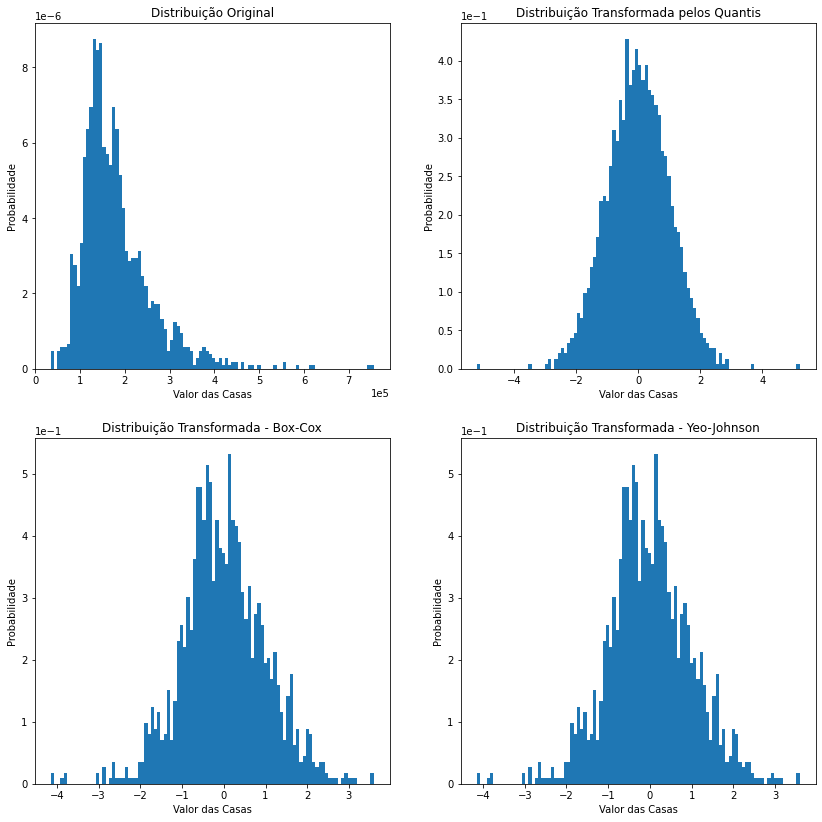

In [10]:
# construindo figuras
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(2, 2, 1)
ax.hist(y, bins=100, density=True)
ax.set_ylabel("Probabilidade")
ax.set_xlabel("Valor das Casas")
ax.set_title("Distribuição Original")
ax.ticklabel_format(axis="both", style="sci", scilimits=(0, 0))

ax = fig.add_subplot(2, 2, 2)
ax.hist(y_quant, bins=100, density=True)
ax.set_ylabel("Probabilidade")
ax.set_xlabel("Valor das Casas")
ax.set_title("Distribuição Transformada pelos Quantis")
ax.ticklabel_format(axis="both", style="sci", scilimits=(0, 0))

ax = fig.add_subplot(2, 2, 3)
ax.hist(y_box, bins=100, density=True)
ax.set_ylabel("Probabilidade")
ax.set_xlabel("Valor das Casas")
ax.set_title("Distribuição Transformada - Box-Cox")
ax.ticklabel_format(axis="both", style="sci", scilimits=(0, 0))

ax = fig.add_subplot(2, 2, 4)
ax.hist(y_johnson, bins=100, density=True)
ax.set_ylabel("Probabilidade")
ax.set_xlabel("Valor das Casas")
ax.set_title("Distribuição Transformada - Yeo-Johnson")
ax.ticklabel_format(axis="both", style="sci", scilimits=(0, 0))

plt.show()

In [11]:
# avaliando o efeito na modelagem

# criando o pipeline
model_pipe = Pipeline([
    ('scaler', pp.StandardScaler()),
    ('model', LinearRegression())])

# separando conjunto de teste
x_train, x_test, y_train_no_tranf, y_test_no_tranf = train_test_split(x, y, test_size=0.3)

# ajuste dos pipelines
model_pipe.fit(x_train, y_train_no_tranf)

# avaliando o desempenho
print(f'Modelo sem Transformação - R2 = {r2_score(y_test_no_tranf, model_pipe.predict(x_test))}')


Modelo sem Transformação - R2 = 0.8200370797575778


In [12]:
# criando o pipeline
model_pipe = Pipeline([
    ('scaler', pp.StandardScaler()),
    ('model', LinearRegression())])

# separando conjunto de teste
x_train, x_test, y_train_quant, y_test_quant = train_test_split(x, y_quant, test_size=0.3)

# ajuste dos pipelines
model_pipe.fit(x_train, y_train_quant)

# avaliando o desempenho
print(f'Modelo Transformação de Quantis - R2 = {r2_score(y_test_quant, model_pipe.predict(x_test))}')

Modelo Transformação de Quantis - R2 = 0.8064541910033407


In [13]:
# criando o pipeline
model_pipe = Pipeline([
    ('scaler', pp.StandardScaler()),
    ('model', LinearRegression())])

# separando conjunto de teste
x_train, x_test, y_train_box, y_test_box = train_test_split(x, y_box, test_size=0.3)

# ajuste dos pipelines
model_pipe.fit(x_train, y_train_box)

# avaliando o desempenho
print(f'Modelo Transformação de Box-Cox - R2 = {r2_score(y_test_box, model_pipe.predict(x_test))}')

Modelo Transformação de Box-Cox - R2 = 0.7381779542630265


In [14]:
# criando o pipeline
model_pipe = Pipeline([
    ('scaler', pp.StandardScaler()),
    ('model', LinearRegression())])

# separando conjunto de teste
x_train, x_test, y_train_johnson, y_test_johnson = train_test_split(x, y_johnson, test_size=0.3)

# ajuste dos pipelines
model_pipe.fit(x_train, y_train_johnson)

# avaliando o desempenho
print(f'Modelo Transformação de Yeo-Johson - R2 = {r2_score(y_test_johnson, model_pipe.predict(x_test))}')

Modelo Transformação de Yeo-Johson - R2 = 0.7499058563779692


### **3.3. Discretização e Agrupamento**

Muitas vezes, pode ocorrer do alvo possuir uma variância que não pode ser explicada totalmente pelos valores individuais dos atributos, somente. Além disso, pode acontecer de alguns atributos possuirem poucos exemplares em determinadas regiões do espaço, de forma que seria muito difícil do modelo compreender os padrões existentes nesse casos. Para alguns atributos, mesmo que ela seja contínua em sua natureza (salário de uma empresa, por exemplo), pode ser que seja interessante analisar a influência de patamares de valores, *como se ela fosse uma variável categórica*. 

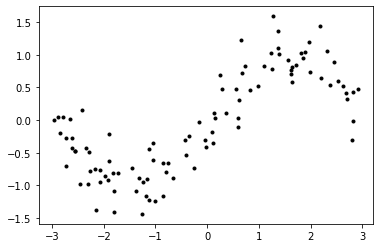

In [16]:
# construindo o dataset
rnd = np.random.RandomState(42)
x = rnd.uniform(-3, 3, size=100)
y = np.sin(x) + rnd.normal(size=len(x)) / 3
x = x.reshape(-1, 1)

plt.plot(x, y, 'k.')

In [17]:
# transformação dos dados com KBinsDiscretizer
enc_3 = pp.KBinsDiscretizer(n_bins=3, encode="onehot")
enc_10 = pp.KBinsDiscretizer(n_bins=10, encode="onehot")
enc_50 = pp.KBinsDiscretizer(n_bins=50, encode="onehot")

x_binned_3 = enc_3.fit_transform(x)
x_binned_10 = enc_10.fit_transform(x)
x_binned_50 = enc_50.fit_transform(x)

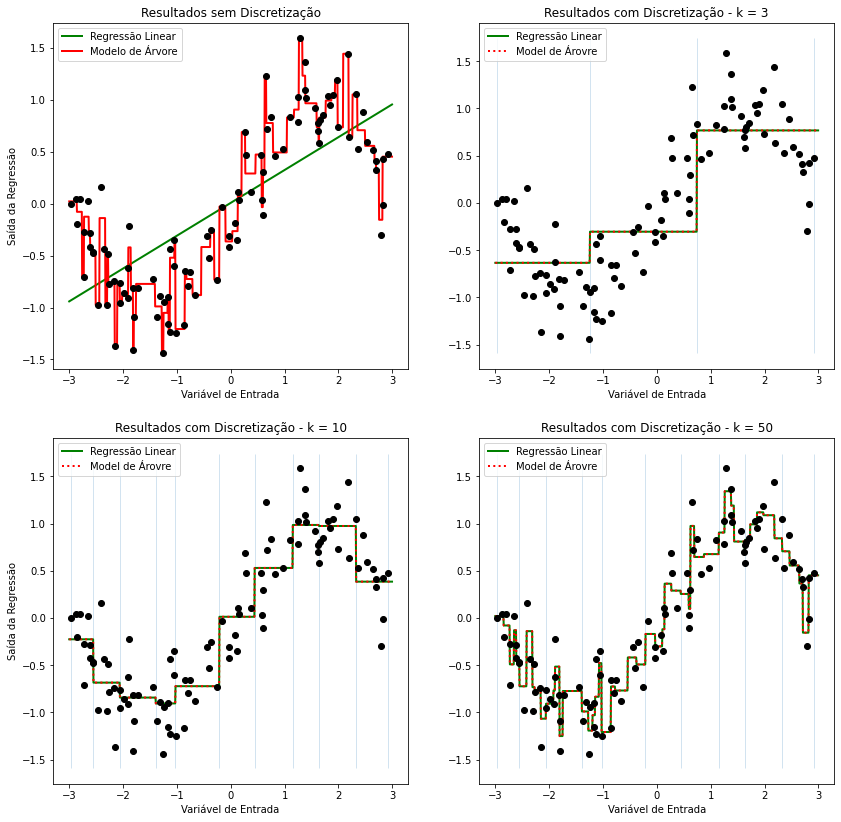

In [22]:
# verificando a qualidade da predição
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)

fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(2, 2, 1)

# modelo Linear
reg = LinearRegression().fit(x, y)
ax.plot(line, reg.predict(line), linewidth=2, color="green", label="Regressão Linear")

# modelo de árvore
reg = DecisionTreeRegressor(min_samples_split=3, random_state=0).fit(x, y)
ax.plot(line, reg.predict(line), linewidth=2, color="red", label="Modelo de Árvore")
ax.plot(x[:, 0], y, "o", c="k")
ax.legend(loc="best")
ax.set_ylabel("Saída da Regressão")
ax.set_xlabel("Variável de Entrada")
ax.set_title("Resultados sem Discretização")

# predição no dataset transformado
ax = fig.add_subplot(2, 2, 2)
line_binned = enc_3.transform(line)
reg = LinearRegression().fit(x_binned_3, y)
ax.plot(
    line,
    reg.predict(line_binned),
    linewidth=2,
    color="green",
    linestyle="-",
    label="Regressão Linear",
)
reg = DecisionTreeRegressor(min_samples_split=3, random_state=0).fit(x_binned_3, y)
ax.plot(
    line,
    reg.predict(line_binned),
    linewidth=2,
    color="red",
    linestyle=":",
    label="Model de Árovre",
)
ax.plot(x[:, 0], y, "o", c="k")
ax.vlines(enc_3.bin_edges_[0], *plt.gca().get_ylim(), linewidth=1, alpha=0.2)
ax.legend(loc="best")
ax.set_xlabel("Variável de Entrada")
ax.set_title("Resultados com Discretização - k = 3")

ax = fig.add_subplot(2, 2, 3)
line_binned = enc_10.transform(line)
reg = LinearRegression().fit(x_binned_10, y)
ax.plot(
    line,
    reg.predict(line_binned),
    linewidth=2,
    color="green",
    linestyle="-",
    label="Regressão Linear",
)
reg = DecisionTreeRegressor(min_samples_split=3, random_state=0).fit(x_binned_10, y)
ax.plot(
    line,
    reg.predict(line_binned),
    linewidth=2,
    color="red",
    linestyle=":",
    label="Model de Árovre",
)
ax.plot(x[:, 0], y, "o", c="k")
ax.vlines(enc_10.bin_edges_[0], *plt.gca().get_ylim(), linewidth=1, alpha=0.2)
ax.legend(loc="best")
ax.set_xlabel("Variável de Entrada")
ax.set_ylabel("Saída da Regressão")
ax.set_title("Resultados com Discretização - k = 10")

ax = fig.add_subplot(2, 2, 4)
line_binned = enc_50.transform(line)
reg = LinearRegression().fit(x_binned_50, y)
ax.plot(
    line,
    reg.predict(line_binned),
    linewidth=2,
    color="green",
    linestyle="-",
    label="Regressão Linear",
)
reg = DecisionTreeRegressor(min_samples_split=3, random_state=0).fit(x_binned_50, y)
ax.plot(
    line,
    reg.predict(line_binned),
    linewidth=2,
    color="red",
    linestyle=":",
    label="Model de Árovre",
)
ax.plot(x[:, 0], y, "o", c="k")
ax.vlines(enc_10.bin_edges_[0], *plt.gca().get_ylim(), linewidth=1, alpha=0.2)
ax.legend(loc="best")
ax.set_xlabel("Variável de Entrada")
ax.set_title("Resultados com Discretização - k = 50")

plt.show()

### **3.4. Atributos Polinomiais**

É uma forma de adicionar complexidade num modelo, sem modificar o modelo em si, simplesmente por considerar atributos polinomiais e não lineares. Por exemplo, usando a classe `PolynomialFeatures` podemos criar mapeamentos para espaços de atributos de maior dimensão. Se usarmos utilizando um grau 2, conseguimos mapear de um espaço bidimensional para as seguintes dimensões.

$$(X_1, X_2) = (1, X_1, X_2, X_1^2, X_1 X_2, X_2^2)$$

Com isso conseguimos capturar relações não-lineares de ordem quadrática, e também conseguimos capturar as relações de interação linear dos atributos. 

**[CUIDADO]:** Devemos lembrar que apesar de ser bem útil para capturar relações não lineares, a classe `PolynomialFeatures` está **adicionando complexidade** ao modelo. É sempre bom monitorar o grau de *overfitting* do modelo, utilizando técnicas de seleção de atributos, regularização e validação cruzada.

In [23]:
# função que será aproximada pela polynomial features
def f(x):
    return x * np.sin(x)

# intervalo de pontos que vamos plotar
x_plot = np.linspace(-1, 11, 100)

In [24]:
# criando a base de treino
x_train = np.linspace(0, 10, 100)
rng = np.random.RandomState(0)
x_train = np.sort(rng.choice(x_train, size=20, replace=False))
y_train = f(x_train)

# criando arrays de duas dimensões
X_train = x_train[:, np.newaxis]
X_plot = x_plot[:, np.newaxis]

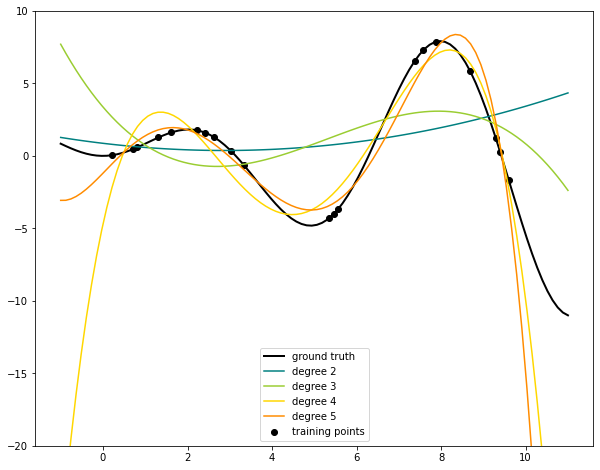

In [25]:
# modificando a espessura da linha
lw = 2

# criando imagem
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_prop_cycle(
    color=["black", "teal", "yellowgreen", "gold", "darkorange", "tomato"]
)
ax.plot(x_plot, f(x_plot), linewidth=lw, label="ground truth")

# plotando pontos de treinamento
ax.scatter(x_train, y_train, label="training points")

# polynomial features
for degree in [2, 3, 4, 5]:
    model = Pipeline([('transf', pp.PolynomialFeatures(degree)), ('model', Ridge(alpha=1e-3))])
    model.fit(X_train, y_train)
    y_plot = model.predict(X_plot)
    ax.plot(x_plot, y_plot, label=f"degree {degree}")

ax.legend(loc="lower center")
ax.set_ylim(-20, 10)
plt.show()

### **3.5. Atributos Temporais**

Pode ser do interesse do analista / modelador, enxergar a influência de atributos de caráter temporal no problema. 

Por exemplo, um determinado alvo do meu modelo pode ter valores significativamente diferentes se formos considerar diferentes dias do mês ou mesmo da semana?

Desta forma, é comum, quando se trabalhar com dados que possuem características temporais, fazermos esse tipo de transformação. Vejamos:

In [26]:
data = pd.read_csv('../datasets/garments_worker_productivity.csv')
data.head()

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


In [27]:
# extraindo dados temporais e o alvo
data = data.loc[:, ['date', 'day', 'actual_productivity']]
data.head()

,date,day,actual_productivity
0,1/1/2015,Thursday,0.940725
1,1/1/2015,Thursday,0.886500
2,1/1/2015,Thursday,0.800570
3,1/1/2015,Thursday,0.800570
4,1/1/2015,Thursday,0.800382


In [28]:
# transformando o tipo das datas
data.date = pd.to_datetime(data.date)
data.head()

,date,day,actual_productivity
0,2015-01-01,Thursday,0.940725
1,2015-01-01,Thursday,0.886500
2,2015-01-01,Thursday,0.800570
3,2015-01-01,Thursday,0.800570
4,2015-01-01,Thursday,0.800382


In [29]:
# criando atributos temporais
data['year'] = data.date.apply(lambda x: x.year)
data['month'] = data.date.apply(lambda x: x.month)
data['day_of_month'] = data.date.apply(lambda x: x.day)
data['weekend'] = data.day.apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)

In [30]:
# produtividade por ano
data.groupby('year')['actual_productivity'].mean()

year
2015    0.735091
Name: actual_productivity, dtype: float64

In [31]:
# produtividade por mês
data.groupby('month')['actual_productivity'].mean()

month
1    0.755415
2    0.717948
3    0.718953
Name: actual_productivity, dtype: float64

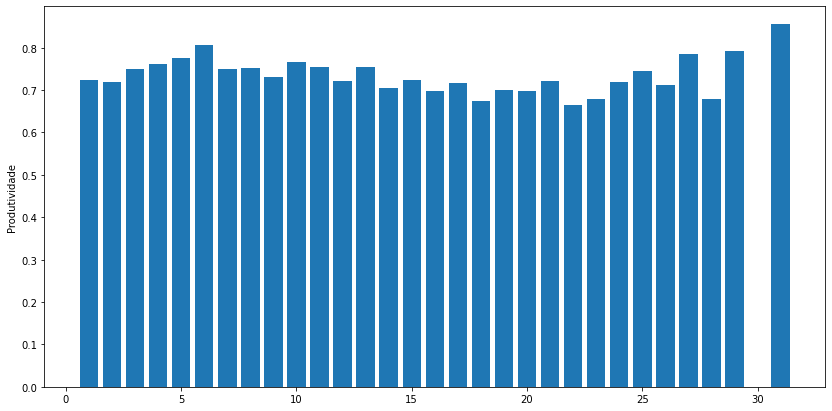

In [32]:
# produtividade por ano
p_day = data.groupby('day_of_month')['actual_productivity'].mean()

plt.figure(figsize=(14, 7))
plt.bar(p_day.index, p_day.values)
plt.ylabel('Produtividade')
plt.show()

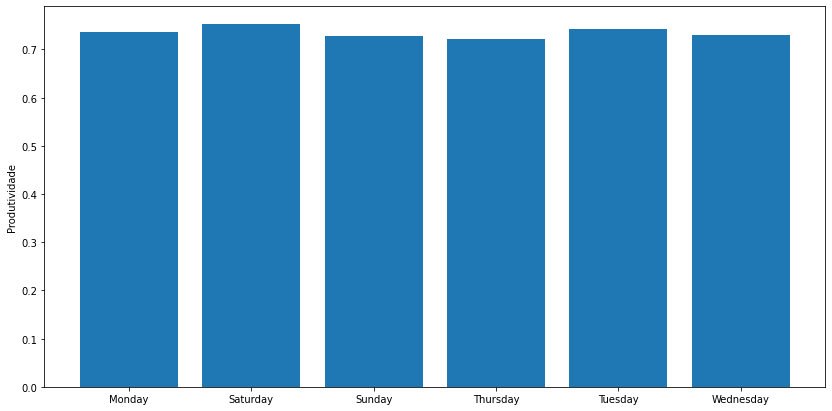

In [33]:
# produtividade por dia da semana
p_day = data.groupby('day')['actual_productivity'].mean()

plt.figure(figsize=(14, 7))
plt.bar(p_day.index, p_day.values)
plt.ylabel('Produtividade')
plt.show()

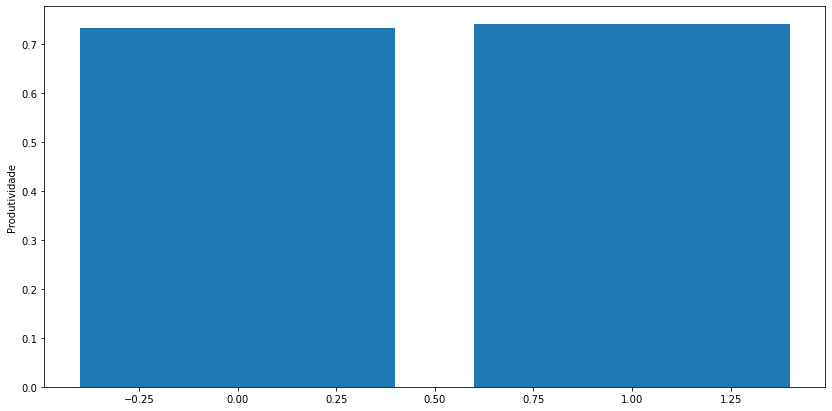

In [34]:
# fator fim de semana
p_day = data.groupby('weekend')['actual_productivity'].mean()

plt.figure(figsize=(14, 7))
plt.bar(p_day.index, p_day.values)
plt.ylabel('Produtividade')
plt.show()